<h1><center>IMT2118 - Ciencia de Datos Geoespaciales (2024-1) </center></h1>
<h2><center>Proyecto:   </center></h2>

### Imports

In [229]:
import pandas as pd
import numpy as np 
import geopandas as gpd
import matplotlib.pyplot as plt
import geemap, ee
from shapely.geometry import LineString, Point
import matplotlib.patches as mpatches

# Initialize Earth Engine
ee.Authenticate()
ee.Initialize()

### Lectura de Datos

In [230]:
stgo = gpd.read_file("Datos/santiago_urbano.gpkg")
roi_shapely = stgo.union_all()

In [231]:
Areas_Verdes = gpd.read_file("Datos/Areas_Verdes.gpkg")
Bomberos = gpd.read_file("Datos/Bomberos.gpkg")
Censo_2017 = gpd.read_file("Datos/Censo_2017.gpkg")
Comercio = gpd.read_file("Datos/Comercio.gpkg")
Ejes = gpd.read_file("Datos/Ejes.gpkg")
EstablecimientosSalud = gpd.read_file("Datos/EstablecimientosSalud.gpkg")
Limite_Comunal = gpd.read_file("Datos/Limite_Comunal.gpkg")
Manzanas = gpd.read_file("Datos/Manzanas.gpkg")
Paraderos = gpd.read_file("Datos/Paraderos.gpkg")

In [232]:
Areas_Verdes = Areas_Verdes[Areas_Verdes.geometry.within(roi_shapely)]
Bomberos = Bomberos[Bomberos.geometry.within(roi_shapely)]
Censo_2017 = Censo_2017[Censo_2017.geometry.within(roi_shapely)]
Comercio = Comercio[Comercio.geometry.within(roi_shapely)]
Ejes = Ejes[Ejes.geometry.within(roi_shapely)]
EstablecimientosSalud = EstablecimientosSalud[EstablecimientosSalud.geometry.within(roi_shapely)]
Manzanas = Manzanas[Manzanas.geometry.within(roi_shapely)]
Paraderos = Paraderos[Paraderos.geometry.within(roi_shapely)]

### Comunas

Filtramos que el Limite comunal solo incluya nuestra zona de interes

In [233]:
Limite_Comunal['geometry'] = Limite_Comunal.geometry.intersection(roi_shapely)
Limite_Comunal = Limite_Comunal[~Limite_Comunal.is_empty]

In [234]:
m = geemap.Map(center=[-33.45, -70.65], zoom=12)
m.add_gdf(stgo, "Santiago Urbano", style={'color': 'blue', 'fillOpacity': 0.1})
m.add_gdf(Limite_Comunal, "Comunas Recortadas", style={'color': 'black', 'fillOpacity': 0.4, 'weight': 2})
m

Map(center=[-33.45, -70.65], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

## Metro

In [235]:
df = pd.read_csv("Datos/plantilla_metro.csv", decimal=',')
for col in ['Lat Origen', 'Long Origen', 'Lat Destino', 'Long Destino']:
    df[col] = df[col].astype(str).str.replace(',', '.').astype(float)

df['geometry'] = df.apply(
    lambda row: LineString([
        (row['Long Origen'], row['Lat Origen']),
        (row['Long Destino'], row['Lat Destino'])
    ]),
    axis=1
)

Metro = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")
Metro['linea'] = Metro['linea'].astype(str)

colores_lineas = {
    '1': 'E1251B',
    '2': 'FFD600',
    '3': '682600',
    '4': '0072BC',
    '4A': '5FAEE2',
    '5': '365A05',
    '6': 'B303DF'
}
Metro['color'] = Metro['linea'].map(colores_lineas)

features = []
for _, row in Metro.iterrows():
    geom = geemap.geopandas_to_ee(gpd.GeoDataFrame([row], crs="EPSG:4326")).geometry()
    feature = ee.Feature(geom).set('style', {
        'color': row['color'],
        'width': 4,
        'lineType': 'solid'
    })
    features.append(feature)

fc = ee.FeatureCollection(features)

m_metro = geemap.Map(center=[-33.45, -70.65], zoom=12)
m_metro.addLayer(fc.style(**{'styleProperty': 'style'}), {}, 'Lineas de Metro')
m_metro


Map(center=[-33.45, -70.65], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [236]:
estaciones = pd.concat([
    Metro[['Estación Origen', 'Lat Origen', 'Long Origen']].rename(
        columns={'Estación Origen': 'Estacion', 'Lat Origen': 'Lat', 'Long Origen': 'Lon'}),
    Metro[['Estación Destino', 'Lat Destino', 'Long Destino']].rename(
        columns={'Estación Destino': 'Estacion', 'Lat Destino': 'Lat', 'Long Destino': 'Lon'})
], ignore_index=True).drop_duplicates(subset=['Estacion'])

estaciones['geometry'] = estaciones.apply(lambda row: Point(row['Lon'], row['Lat']), axis=1)
gdf_estaciones = gpd.GeoDataFrame(estaciones, geometry='geometry', crs="EPSG:4326")

gdf_estaciones_comunas = gpd.sjoin(gdf_estaciones, Limite_Comunal, how='left', predicate='within')

conteo = gdf_estaciones_comunas['comuna'].value_counts().sort_index()

comunas_todas = Limite_Comunal['comuna'].unique()

comunas_sin_metro = set(comunas_todas) - set(conteo.index)

#print("Estaciones de metro por comuna:")
#print(conteo)
print("Comunas sin estaciones de metro:")
print(sorted(comunas_sin_metro))


Comunas sin estaciones de metro:
['CERRO NAVIA', 'COLINA', 'HUECHURABA', 'LA PINTANA', 'LAMPA', 'LO BARNECHEA', 'LO ESPEJO', 'RENCA', 'VITACURA']


In [237]:
# Crear personas_por_comuna agrupando por nombre de comuna
personas_por_comuna = Manzanas.groupby('DES_COMU')['PERSONAS'].sum()

# Filtrar las comunas sin metro en personas_por_comuna
personas_sin_metro = personas_por_comuna[personas_por_comuna.index.isin(comunas_sin_metro)]
print(personas_sin_metro)
print(f"Total de personas en comunas sin metro: {personas_sin_metro.sum()}")

DES_COMU
CERRO NAVIA     120684
HUECHURABA       51721
LA PINTANA      174065
LAMPA                4
LO BARNECHEA     60448
LO ESPEJO        98651
RENCA           110913
VITACURA         76696
Name: PERSONAS, dtype: int64
Total de personas en comunas sin metro: 693182


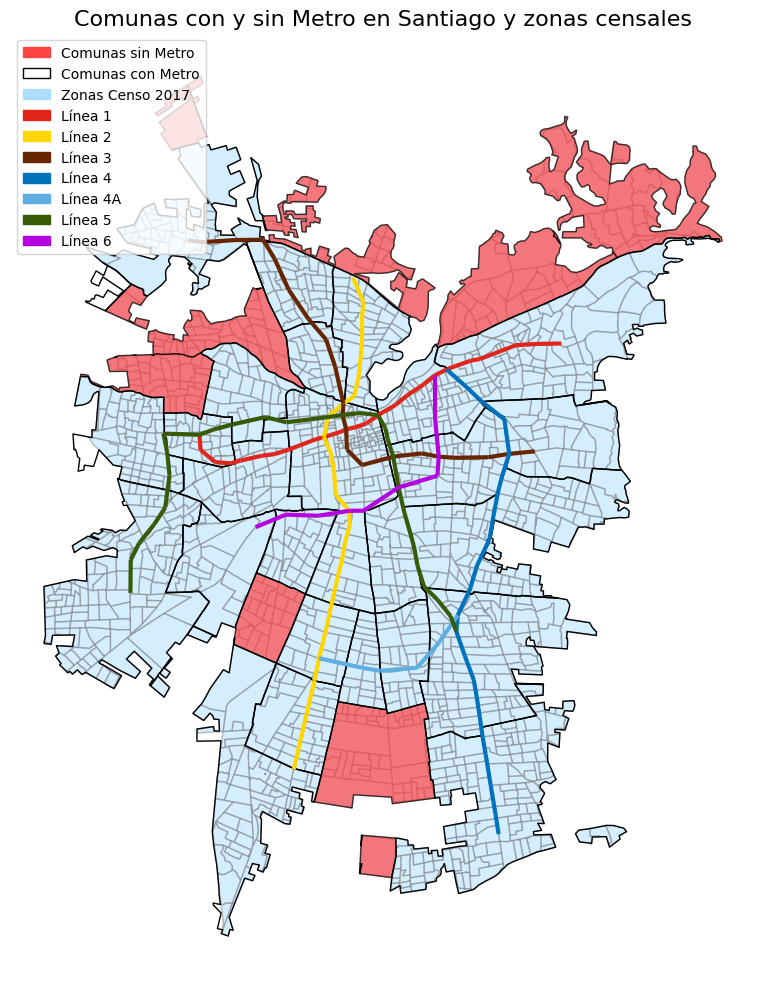

In [246]:
zonas = gpd.read_file("Datos/datosZonas_Stgo_C2017.gpkg")
zonas = zonas.to_crs(Limite_Comunal.crs)


Limite_Comunal['sin_metro'] = Limite_Comunal['comuna'].str.upper().isin(comunas_sin_metro)

fig, ax = plt.subplots(figsize=(12, 10))

# Zonas censales
zonas.plot(ax=ax, color='#aaddff', edgecolor='gray', alpha=0.5, label='Zonas Censo 2017')

# Comunas sin metro
Limite_Comunal[Limite_Comunal['sin_metro']].plot(
    ax=ax, color='#ff4444', edgecolor='black', linewidth=1, alpha=0.7, label='Comunas sin Metro'
)

# Comunas con metro
Limite_Comunal[~Limite_Comunal['sin_metro']].plot(
    ax=ax, facecolor='none', edgecolor='black', linewidth=1, alpha=1, label='Comunas con Metro'
)

# Líneas de metro
for linea, color in colores_lineas.items():
    Metro[Metro['linea'] == linea].plot(
        ax=ax, color=f'#{color}', linewidth=3, label=f'Línea {linea}'
    )

# Leyenda manual
leyenda = [
    mpatches.Patch(color='#ff4444', label='Comunas sin Metro'),
    mpatches.Patch(facecolor='none', edgecolor='black', label='Comunas con Metro'),
    mpatches.Patch(color='#aaddff', label='Zonas Censo 2017')
]
for linea, color in colores_lineas.items():
    leyenda.append(mpatches.Patch(color=f'#{color}', label=f'Línea {linea}'))

ax.legend(handles=leyenda, loc='upper left', fontsize=10)
ax.set_title('Comunas con y sin Metro en Santiago y zonas censales', fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()


## Mapas Varios

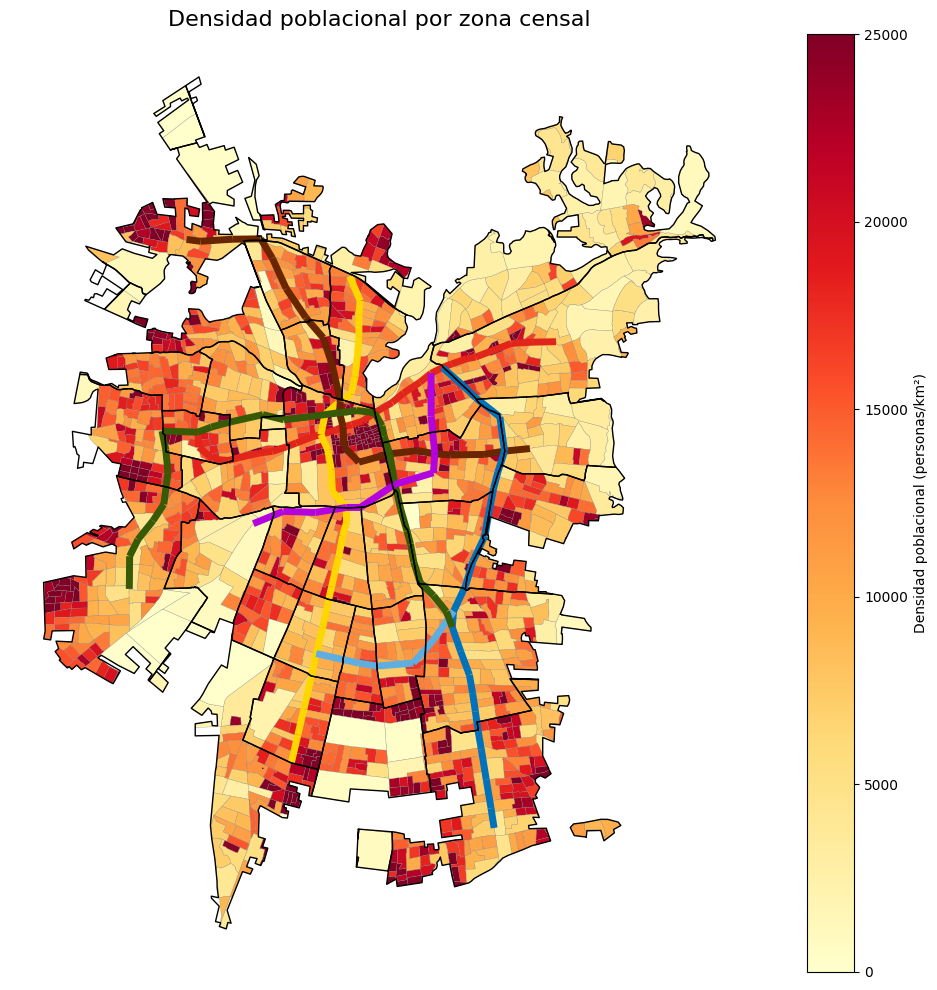

In [247]:
zonas_proj = zonas.to_crs(epsg=32719)
zonas['area_km2'] = zonas_proj.geometry.area / 1e6

zonas['densidad'] = zonas['PERSONAS'] / zonas['area_km2']

fig, ax = plt.subplots(figsize=(12, 10))

vmax = 25000

for linea, color in colores_lineas.items():
    Metro[Metro['linea'] == linea].plot(ax=ax, color=f'#{color}', linewidth=5, label=f'Línea {linea}')

zonas.plot(
    column='densidad', ax=ax, cmap='YlOrRd', legend=True, 
    legend_kwds={'label': "Densidad poblacional (personas/km²)"},
    edgecolor='gray', linewidth=0.2, vmax=vmax)

Limite_Comunal.boundary.plot(ax=ax, color='black', linewidth=1)
ax.set_title('Densidad poblacional por zona censal', fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

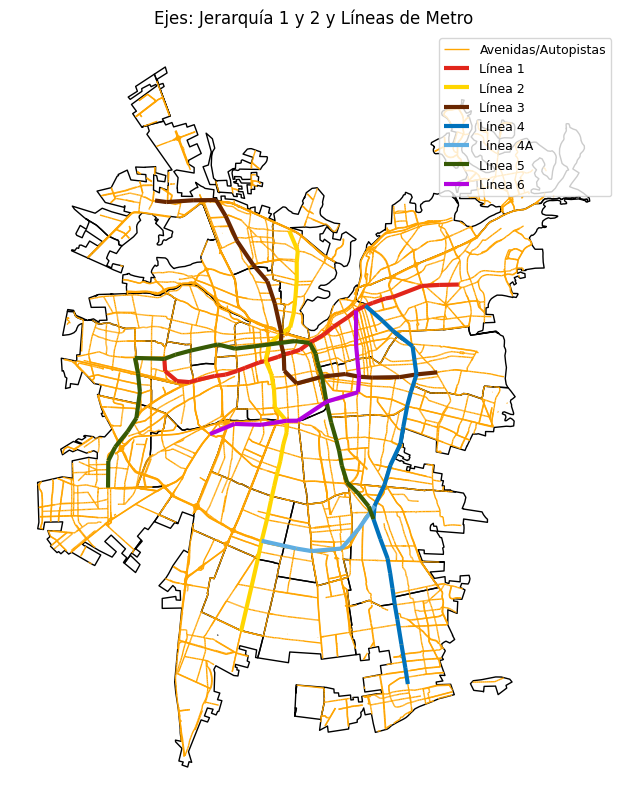

In [248]:
# Filtro Avenidas y Autopistas
filtro_jerarquia = Ejes["hierarchy"].isin([1, 2])
Ejes_jerarquia = Ejes[filtro_jerarquia]

Ejes_jerarquia = Ejes_jerarquia[Ejes_jerarquia.is_valid]
fig, ax = plt.subplots(figsize=(12, 10))
Ejes_jerarquia.plot(ax=ax, color='orange', linewidth=1, label='Avenidas/Autopistas')
Limite_Comunal.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, label='Límite Comunal')

# Agregar líneas de metro
for linea, color in colores_lineas.items():
    Metro[Metro['linea'] == linea].plot(
        ax=ax,
        color=f'#{color}',
        linewidth=3,
        label=f'Línea {linea}'
    )

ax.set_title("Ejes: Jerarquía 1 y 2 y Líneas de Metro")
ax.axis('off')

# Leyenda personalizada para evitar duplicados
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), fontsize=9)

plt.show()

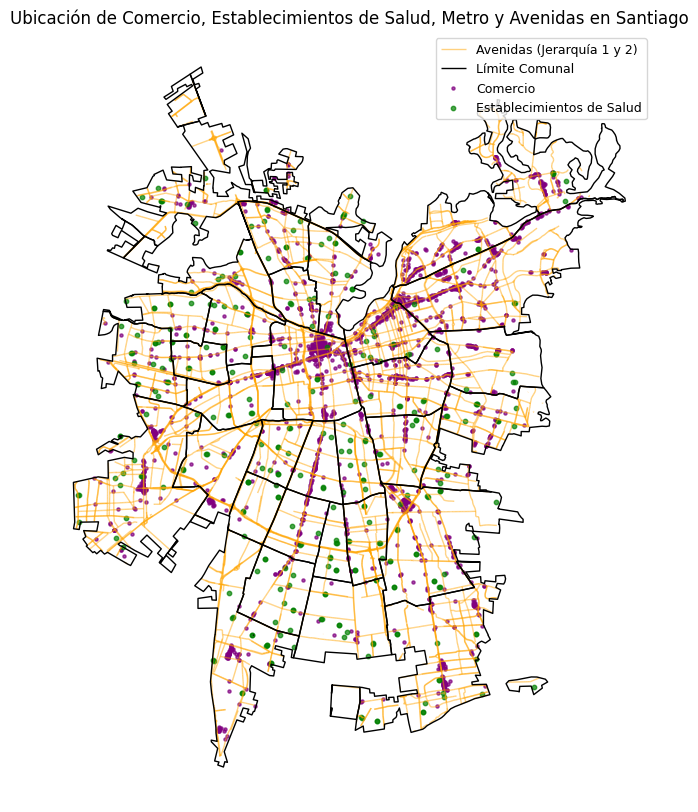

In [249]:
fig, ax = plt.subplots(figsize=(10, 10))

# 1. Avenidas (Ejes jerarquía 1 y 2) al fondo
Ejes_jerarquia.plot(ax=ax, color='orange', linewidth=1, alpha=0.5, label='Avenidas (Jerarquía 1 y 2)')

# 3. Límite comunal
Limite_Comunal.boundary.plot(ax=ax, color='black', linewidth=1, label='Límite Comunal')

# 4. Comercio
Comercio.plot(ax=ax, color='purple', markersize=5, alpha=0.7, label='Comercio')

# 5. Establecimientos de Salud
EstablecimientosSalud.plot(ax=ax, color='green', markersize=10, alpha=0.7, label='Establecimientos de Salud')

ax.set_title('Ubicación de Comercio, Establecimientos de Salud, Metro y Avenidas en Santiago')
ax.axis('off')

# Leyenda personalizada para evitar duplicados
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), fontsize=9)

plt.show()

## Imagenes Satelitales

In [242]:
gran_santiago = ee.Geometry.Polygon([
    [[-70.9, -33.8], [-70.9, -33.2], [-70.3, -33.2], [-70.3, -33.8]]
])

def check_images_per_year(start_year, end_year):
    for year in range(start_year, end_year + 1):
        start_date = f'{year}-01-01'
        end_date = f'{year}-12-31'
        collection = (
            ee.ImageCollection('COPERNICUS/S2_SR')
            .filterDate(start_date, end_date)
            .filterBounds(gran_santiago)
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
        )
        count = collection.size().getInfo()
        print(f'Año {year}: {count} imágenes disponibles.')

check_images_per_year(2018, 2025)

Año 2018: 13 imágenes disponibles.
Año 2019: 117 imágenes disponibles.
Año 2020: 125 imágenes disponibles.
Año 2021: 108 imágenes disponibles.
Año 2022: 179 imágenes disponibles.
Año 2023: 157 imágenes disponibles.
Año 2024: 156 imágenes disponibles.
Año 2025: 89 imágenes disponibles.


In [243]:
gran_santiago = ee.Geometry.Polygon([
    [[-70.9, -33.8], [-70.9, -33.2], [-70.3, -33.2], [-70.3, -33.8]]
])

def mask_s2_sr_clouds(image):
    cloud_prob = image.select('MSK_CLDPRB')
    cloud_mask = cloud_prob.lt(20)
    return image.updateMask(cloud_mask).copyProperties(image, ["system:time_start"])

def get_annual_composite(year):
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    collection = (
        ee.ImageCollection('COPERNICUS/S2_SR')
        .filterDate(start_date, end_date)
        .filterBounds(gran_santiago)
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
        .map(mask_s2_sr_clouds)
    )
    count = collection.size().getInfo()
    if count == 0:
        print(f"No hay imágenes para el año {year}")
        return None
    median_image = collection.median().clip(gran_santiago)
    return median_image

def urban_index(image):
    return image.normalizedDifference(['B11', 'B8']).rename('NDBI')


ndbi_2018 = urban_index(get_annual_composite(2019))
ndbi_2025 = urban_index(get_annual_composite(2023))

ndbi_diff = ndbi_2025.subtract(ndbi_2018).rename('NDBI_Diff')

Map = geemap.Map(center=[-33.45, -70.65], zoom=11)

diff_vis = {
    'min': -0.5,
    'max': 0.5,
    'palette': [
        '006837',  # verde oscuro (vegetación densa, menos urbano)
        '1a9850',  # verde
        '66bd63',  # verde claro
        '000000',  # amarillo pálido (sin cambio)
        'f46d43',  # naranja
        'd73027',  # rojo (más urbano)
        'a50026'   # rojo oscuro (urbanización intensa)
    ]
}
Map.addLayer(ndbi_diff, diff_vis, 'Cambio NDBI 2019–2023')

Map.add_gdf(Limite_Comunal, layer_name='Límites comunales', style={'color': 'white', 'weight': 1.5})

Map.addLayerControl()
Map

Map(center=[-33.45, -70.65], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

Vemos que mayoritariamente, el desarrollo urbano tiene tendencia hacia las afueras de santiago, puede afectar los años de estudio, que son años de estallido social y pandemia, entonces puede ser una idea importante no centrar el transporte en la zona central o ya urbanizada de santiago, si no que expandir el transporte publico, para tener un mejor acceso a comunas como Colina, Lampa, talagante, Peñaflor

In [244]:
Limite_Comunal_full = gpd.read_file("Datos/Limite_Comunal.gpkg")
m = geemap.Map(center=[-33.45, -70.65], zoom=12)
m.add_gdf(stgo, "Santiago Urbano", style={'color': 'blue', 'fillOpacity': 0.1})
m.add_gdf(Limite_Comunal_full, "Comunas Recortadas", style={'color': 'black', 'fillOpacity': 0.4, 'weight': 2})
m

Map(center=[-33.45, -70.65], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…